In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

weather_data = pd.read_csv('../data/miami_weather_combined_daily.csv')
weather_data.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,1940-01-02 00:00:00+00:00,51.0,73.2551,55.975100,76.509415,56.151590,0,0,38043.188,33700.754,0.7,0.7,0.0,5.0,8.891343,19.080000,249.737820,12.84,2.245749
1,1940-01-03 00:00:00+00:00,51.0,71.2751,62.725100,71.049230,63.447296,0,0,38068.445,32820.055,1.3,1.3,0.0,6.0,13.202726,26.280000,338.600130,12.65,2.253451
2,1940-01-04 00:00:00+00:00,53.0,76.2251,59.755100,78.883640,58.821480,0,0,38095.598,31149.346,1.0,1.0,0.0,5.0,13.513193,33.120000,62.664597,12.31,2.284541
3,1940-01-05 00:00:00+00:00,61.0,77.5751,63.175102,80.216590,65.592500,0,0,38124.610,33770.555,1.7,1.7,0.0,5.0,16.099690,39.239998,207.818710,12.85,2.319135
4,1940-01-06 00:00:00+00:00,53.0,75.7751,62.815100,78.979230,65.418960,0,0,38155.445,30616.383,1.3,1.3,0.0,6.0,10.972620,22.319998,340.736360,11.35,2.140070


Mean Absolute Error (MAE): 2.053788305018011
Root Mean Squared Error (RMSE): 2.7979511612501073
explained_variance_score: 0.7707283073543743


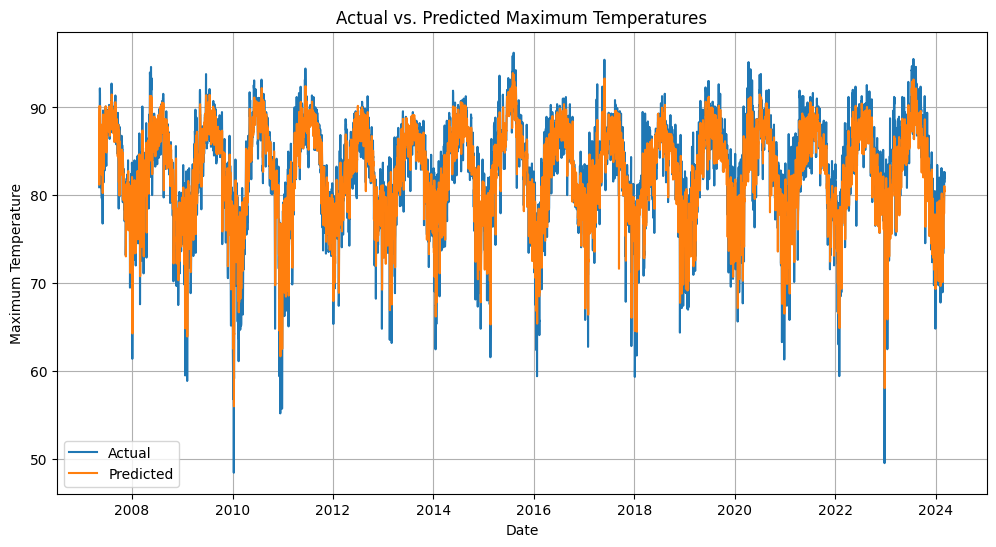

In [11]:
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['day_of_year'] = weather_data['date'].dt.dayofyear

# Create sinusoidal features
weather_data['sin_day'] = np.sin(2 * np.pi * weather_data['day_of_year'] / 365)
weather_data['cos_day'] = np.cos(2 * np.pi * weather_data['day_of_year'] / 365)

# Add a feature for yesterday's data
weather_data['yesterday_max_temp'] = weather_data['temperature_2m_max'].shift(1)
weather_data['yesterday_min_temp'] = weather_data['temperature_2m_min'].shift(1)
weather_data['yesterday_wind_speed'] = weather_data['wind_speed_10m_max'].shift(1)
weather_data['wind_gusts_10m_max'] = weather_data['wind_gusts_10m_max'].shift(1)
weather_data['apparent_temperature_max'] = weather_data['apparent_temperature_max'].shift(1)

# Create a new DataFrame with relevant features
data = weather_data[['date', 'day_of_year', 'sin_day', 'cos_day', 'temperature_2m_max', 'yesterday_max_temp', 'yesterday_min_temp', 'yesterday_wind_speed','wind_gusts_10m_max', 'apparent_temperature_max']]
data = data.dropna()

# Convert the data to numpy arrays
X = data[['sin_day','cos_day', 'yesterday_max_temp', 'yesterday_min_temp', 'yesterday_wind_speed', 'wind_gusts_10m_max', 'apparent_temperature_max']].values
y = data['temperature_2m_max'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("explained_variance_score:", explained_variance_score(y_test, y_pred))

# Get the corresponding dates for the testing set
test_dates = data['date'].iloc[-len(X_test):]

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs. Predicted Maximum Temperatures')
plt.legend()
plt.grid(True)
plt.show()